In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
if __name__ == '__main__':
    from findatapy.util import SwimPool; SwimPool()

    from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

    market = Market(market_data_generator=MarketDataGenerator())

    md_request = MarketDataRequest(
        start_date="01 Jun 2000",
        data_source='fred',tickers=['DGS10'],
        fields=['close'],
        vendor_tickers=['DGS10'], 
        vendor_fields=['close'])
    
    df = market.fetch_market(md_request)

2017-09-06 12:33:13,118 - findatapy.market.datavendorweb - INFO - Request Pandas Web data
2017-09-06 12:33:15,832 - findatapy.market.datavendorweb - INFO - Completed request from Pandas Web.
2017-09-06 12:33:15,936 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_359__abstract_curve_key-None__category-None__category_key-backtest_default-cat_fred_daily_NYC__cut-NYC__data_source-fred__environment-backtest__expiry_date-None__fields-close__finish_date-2017-09-06 03:33:12_429402__freq-daily__freq_mult-1__gran_freq-None__start_date-2000-06-01 00:00:00__tickers-DGS10__trade_side-trade__vendor_fields-close__vendor_tickers-DGS10 to Redis: Error 61 connecting to 127.0.0.1:6379. Connection refused.


In [4]:
df = df.reset_index()
df = df.rename(columns={'Date':'ds','DGS10.close':'y'})
df['y'] = np.log(df['y'])
df.head()

,ds,y
0,2000-06-01,1.824549
1,2000-06-02,1.816452
2,2000-06-05,1.811562
3,2000-06-06,1.814825
4,2000-06-07,1.813195


In [5]:
#csv出力
df.to_csv('output.csv',sep=',')

In [11]:
#fill forward values when the datasets has N/A
df.isnull().sum()
df.fillna(method='ffill').head()

,ds,y
0,2000-06-01,1.824549
1,2000-06-02,1.816452
2,2000-06-05,1.811562
3,2000-06-06,1.814825
4,2000-06-07,1.813195


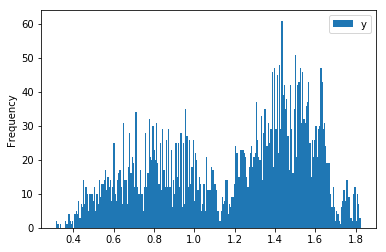

In [14]:
df.plot(kind='hist',bins=250,subplots=True)
plt.show()

In [21]:
#Making a Prediction
#　Create the First Model
from fbprophet import Prophet
model = Prophet()
model.fit(df)

In [23]:
#1years = 200days 
future_df = model.make_future_dataframe(200*3)

future_df.tail()

,ds
5097,2019-04-20
5098,2019-04-21
5099,2019-04-22
5100,2019-04-23
5101,2019-04-24


In [24]:
#add columns yhat_lower,yhat_upper
forecast_df = model.predict(future_df)
forecast_df[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5097,2019-04-20,0.575572,0.308501,0.887496
5098,2019-04-21,0.576060,0.327160,0.890840
5099,2019-04-22,0.570618,0.318705,0.894707
5100,2019-04-23,0.569489,0.301217,0.868902
5101,2019-04-24,0.570232,0.326014,0.897361


In [25]:
np.exp(forecast_df[['yhat','yhat_lower','yhat_upper']].tail())

,yhat,yhat_lower,yhat_upper
5097,1.778147,1.361383,2.429041
5098,1.779015,1.387023,2.437177
5099,1.769359,1.375346,2.446618
5100,1.767363,1.351502,2.384293
5101,1.768678,1.385435,2.453120


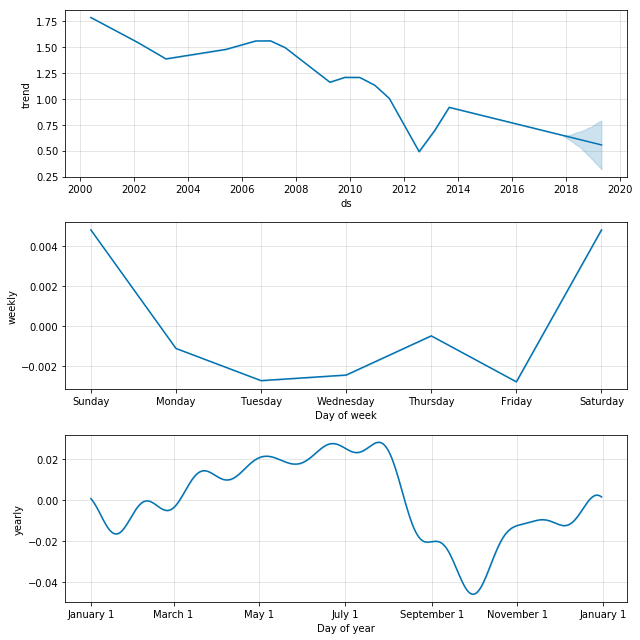

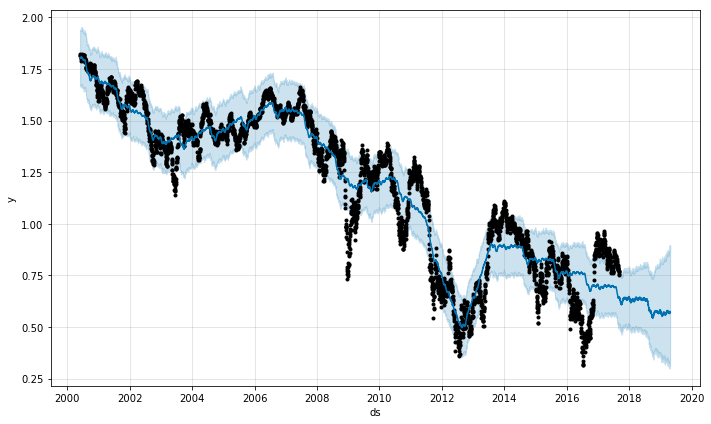

In [26]:
model.plot(forecast_df)
plt.show()

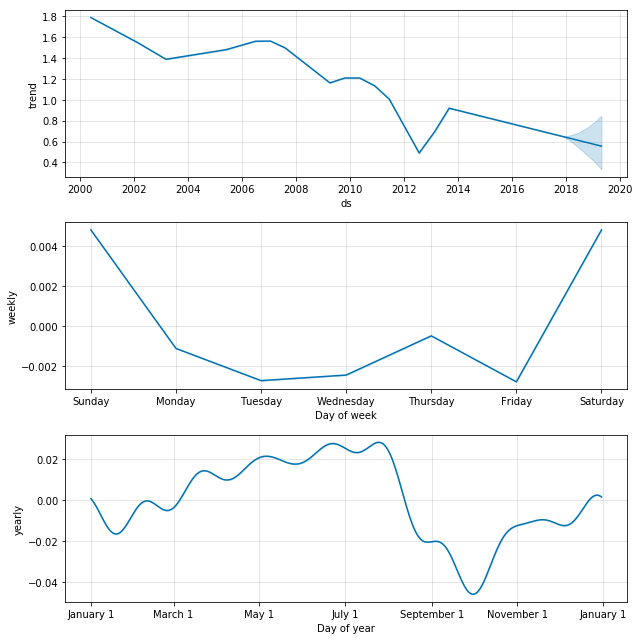

In [27]:
model.plot_components(forecast_df)